### Регрессия

### -- Автор: Шенк Евгений Станиславович

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
Data_loaded = pd.read_csv('train.csv')
Data = Data_loaded.values
X = Data_loaded.loc[:,'Id':'history'].values
y = Data_loaded.mean_exam_points.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2177)

In [3]:
Test_data = pd.read_csv('test.csv').values
Submission = pd.read_csv('submission_example.csv')

### Дерево

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        prediction = np.mean(self.labels)
        return prediction      

In [6]:
# Расчет качества

def quality(left_labels, right_labels, current_var):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_var - p * np.var(left_labels) - (1 - p) * np.var(right_labels)

In [7]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [8]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    #len_subsample = int(np.sqrt(len_sample))
    len_subsample = int((len_sample))
    subsample = []
    
    random.seed(42)
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_leaf):
    
    #  обозначим минимальное количество объектов в узле
    # min_leaf = 5
    min_data_len = len(data) * min_leaf / 100

    current_var = np.var(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    # subsample = get_subsample(n_features)
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            #if len(true_data) < min_leaf or len(false_data) < min_leaf:
            if len(true_data) < min_data_len or len(false_data) < min_data_len:
                continue
            
            current_quality = quality(true_labels, false_labels, current_var)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [10]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [11]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [12]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [13]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, min_leaf=10, max_leaves=20, tree_depth=20):

    quality, t, index = find_best_split(data, labels, min_leaf)

    #  1. Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    #  2. прекращаем рекурсию, когда достигнута максимальная глубина дерева
    #  3. прекращаем рекурсию, когда достигнуто максимальное количество листьев 
    #  (количество листьев считаем по кол-ву Нодов + 1)    
    if quality == 0 or tree_depth == 0 or max_leaves <= 1:
        max_leaves += 1
        return Leaf(data, labels), max_leaves

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    max_leaves -= 2
    
    # Рекурсивно строим два поддерева
    true_branch, max_leaves = build_tree(true_data, true_labels, min_leaf, max_leaves, tree_depth = tree_depth - 1)
    false_branch, max_leaves = build_tree(false_data, false_labels, min_leaf, max_leaves, tree_depth = tree_depth - 1)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch), max_leaves

## Градиентный бустинг

In [14]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [15]:
def bias(y, z):
    return (y - z)

In [16]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * classify_object(x, alg) for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [17]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree = build_tree(X_train, y_train, tree_depth=max_depth)[0]
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree = build_tree(X_train, bias(y_train, target), tree_depth=max_depth)[0]
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [18]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [19]:
# Грфик зависимости MSE от количества деревьев (итераций)
def get_error_plot_n_trees(start, n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(start, n_trees)
    plt.plot(list(range(start, n_trees)), train_err[start:n_trees], label='train error')
    plt.plot(list(range(start, n_trees)), test_err[start:n_trees], label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [20]:
# Грфик зависимости MSE от максимальной глубины дерева
def get_error_plot_max_depth(max_depth, train_err, test_err):
    plt.xlabel('Max_depth')
    plt.ylabel('MSE')
    plt.xlim(1, max_depth)
    plt.plot(list(range(1, max_depth)), train_err, label='train error')
    plt.plot(list(range(1, max_depth)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [21]:
n_trees = 60
coefs = [1.0 - 0.015 * x for x in np.arange(0, n_trees, 1)]
max_depth = 6
eta = 0.2

trees_6, train_errors_6, test_errors_6 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
trees_6a, train_errors_6a, test_errors_6a = gb_fit(n_trees, max_depth, X, X_test, y, y_test, coefs, eta)

test_prediction_6 = gb_predict(X_test, trees_6, coefs, eta)

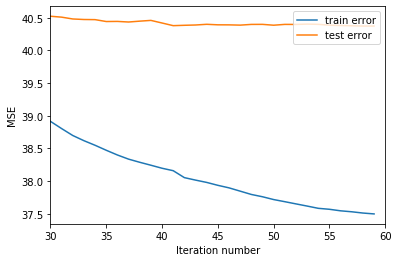

In [22]:
get_error_plot_n_trees(30, n_trees, train_errors_6, test_errors_6)

In [25]:
# Test Data
test_prediction_6 = gb_predict(Test_data, trees_6, coefs, eta)

# Опробованные варианты

In [111]:
"""n_trees = 40
coefs = [1 - 0.02 * x for x in np.arange(0, n_trees, 1)]
max_depth = 6
eta = 0.2
min_leaf=1

Submission_1 = Submission.copy()
Submission_1['mean_exam_points'] = test_prediction
Submission_1.to_csv('Submission_1.csv', index=False)"""

"\nn_trees = 40\ncoefs = [1 - 0.02 * x for x in np.arange(0, n_trees, 1)]\nmax_depth = 6\neta = 0.2\n\nSubmission_1 = Submission.copy()\nSubmission_1['mean_exam_points'] = test_prediction\nSubmission_1.to_csv('Submission_1.csv', index=False)\n"

In [178]:
"""n_trees = 42
coefs = [1 - 0.01 * x for x in np.arange(0, n_trees, 1)]
max_depth = 4
eta = 0.2
min_leaf=1

Submission_2 = Submission.copy()
Submission_2['mean_exam_points'] = test_prediction
Submission_2.to_csv('Submission_1.csv', index=False)"""

In [350]:
"""n_trees = 20
coefs = [1 - 0.02 * x for x in np.arange(0, n_trees, 1)]
max_depth = 4
eta = 0.3
min_leaf=1

Submission_4 = Submission.copy()
Submission_4['mean_exam_points'] = test_prediction_4
Submission_4.to_csv('Submission_4.csv', index=False)"""

In [351]:
"""n_trees = 20
coefs = [1 - 0.02 * x for x in np.arange(0, n_trees, 1)]
max_depth = 6
eta = 0.3
min_leaf=1

Submission_5 = Submission.copy()
Submission_5['mean_exam_points'] = test_prediction_6
Submission_5.to_csv('Submission_5.csv', index=False)"""

In [482]:
"""n_trees = 40
coefs = [1 - 0.02 * x for x in np.arange(0, n_trees, 1)]
max_depth = 6
eta = 0.2
min_leaf=15

Submission_6 = Submission.copy()
Submission_6['mean_exam_points'] = test_prediction_6
Submission_6.to_csv('Submission_6.csv', index=False)"""

In [26]:
# Последний вариант 0.77745 score

"""n_trees = 60
coefs = [1.0 - 0.015 * x for x in np.arange(0, n_trees, 1)]
max_depth = 6
eta = 0.2
min_leaf=15"""

Submission_7 = Submission.copy()
Submission_7['mean_exam_points'] = test_prediction_6
Submission_7.to_csv('Submission_7.csv', index=False)